In [2]:
from pycocotools.coco import COCO
import csv
import requests
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import cv2
import sys

sys.path.append('../')
from project_utils import helpers as H

H.expand_jupyter_screen()

# Coco-dataset - cell_phone only
This requries the that the file `instances_train2017.json` has been downloaded from: <br> https://cocodataset.org/#download


In [2]:
# Builds upon trandinhson3086's github:
# https://github.com/trandinhson3086/cell-phone-detection-using-yolov3/blob/master/phone_download.py

coco = COCO('../input/coco-anno/annotations/instances_train2017.json')
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

catIds = coco.getCatIds(catNms=['cell phone'])
imgIds = coco.getImgIds(catIds=catIds )
images = coco.loadImgs(imgIds)
print("imgIds: ", len(imgIds))
print("images: ", len(images))


#Download cell_phone annotations
with open('annotations_download_' + 'cell phone' + '.csv', mode='w', newline='') as annot:
    for im in images:
        annIds = coco.getAnnIds(imgIds=im['id'], catIds=catIds, iscrowd=None)
        anns = coco.loadAnns(annIds)
        for i in range(len(anns)):
            x_min, y_min, width, height = [int(a) for a in anns[i]["bbox"]]
            annot_writer = csv.writer(annot)
            annot_writer.writerow([im["coco_url"], x_min, y_min, x_min + width, y_min + height, 'cell phone'])
            
annot.close()
df = pd.read_csv("./annotations_download_cell phone.csv", header=None)
df = df.rename(columns={i:name for i, name in enumerate(["url", "x1", "y1", "x2", "y2", "label"])})
df.to_csv("./annotations_download_cell phone.csv", index=False)
df

df_main = pd.read_csv("C:/Users/JK/Desktop/datasets/coco_cell_phone/annotations_download_cell phone.csv")

# Train-validation split
Just a simple random split, there's no point in anything fancy given that there's only a single class. I do however need to make sure the amount of train/validation samples are equivalent with that of the mask dataset. That's roughly 4000-8000 training samples and 150-300 validation samples. This correspond to a test_size of ~4\%

In [3]:
import sklearn.model_selection
df_train, df_valid = sklearn.model_selection.train_test_split(df_main, test_size=0.04, random_state=0)
df_train.reset_index(drop=True), df_valid.reset_index(drop=True)
len(df_train), len(df_valid)

(6176, 258)

# Sanity check

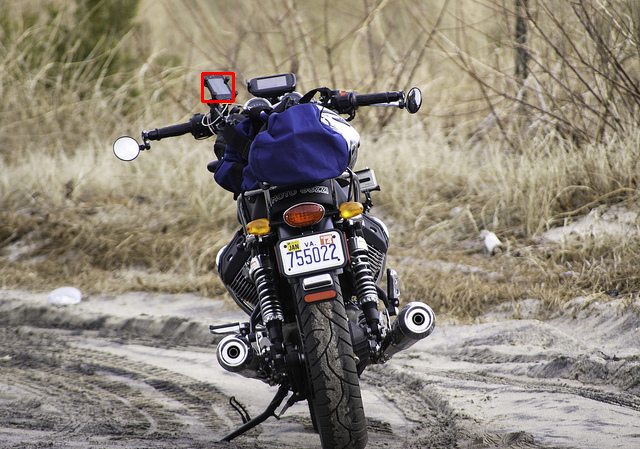

,url,x1,y1,x2,y2,label
0,http://images.cocodataset.org/train2017/000000...,202,73,233,101,cell phone


In [4]:
sample_image = H.get_image_from_url(df_main.url[0], "cv2")
sample_df = df_main[df_main.url == df_main.url[0]]
x1, y1, x2, y2 = sample_df.iloc[0]["x1":"y2"]
cv2.rectangle(sample_image, (x1,y1), (x2,y2), (255,0,0), 2)
H.cv2_show_image(sample_image[:,:,::-1])
display(sample_df)

# Download the dataset
There's 3 labels in the mask dataset `[0,1,2]` so gonna assign `cell_phone` to the label `3`

In [15]:
yolo_dataset_path = ?"C:/Users/JK/Desktop/datasets/coco_cell_phone/"

for df, dataset_type in [[df_train, "train"], [df_valid, "valid"]]:
    print(f"{dataset_type} dataset is being made...")
    for url in tqdm(df.url.unique()):
        file_name = "coco_cell_phone_" + url.split("/")[-1] # extract the actual file name from the url
        df_subset = df[df.url == url]
        
        # Download and save image
        to_path = f"{yolo_dataset_path}/images/{dataset_type}/{file_name}"
        img = H.get_image_from_url(url, return_type="cv2")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(to_path, img)
        
        # Extract bb-coordinates and convert them to YOLO-format
        height, width = img.shape[:2]
        to_file_string = ""
        for index, item in df_subset.iterrows():
            string = H.normal_bb_coordinates_to_yolo_format(list(item["x1":"y2"]), 
                                                            img_width=width, 
                                                            img_height=height, 
                                                            label=3, xywh=False)
            
            to_file_string += string + "\n"
        to_file_string = to_file_string # delete the last "\n"

        # Create annotations
        file_name_txt = file_name[:-len(H.extract_file_extension(file_name))] + ".txt"
        annotation_path = f"{yolo_dataset_path}/labels/{dataset_type}/{file_name_txt}"
        H.write_to_file( annotation_path, to_file_string)      
        
        if debug:
            print(df_subset)
            img = H.yolo_draw_bbs_path(to_path, annotation_path)
            H.cv2_show_image(img)
        
        
# Saving dataframes for good measure
df_train.to_csv(yolo_dataset_path + "df_train.csv", index=False)
df_valid.to_csv(yolo_dataset_path + "df_valid.csv", index=False)